**Introduction**

This notebook demonstrates how to compile and run the HuggingFace Stable Diffusion 1.5 (512x512) model for accelerated inference on Neuron.

This Jupyter notebook should be run on an Inf2 instance (`inf2.8xlarge` or larger for compilation).

**Install Dependencies**

This tutorial requires the following pip packages to be installed:
- `torch-neuronx`
- `neuronx-cc`
- `diffusers==0.14.0`
- `transformers==4.26.1`
- `accelerate==0.16.0`
- `matplotlib`

`torch-neuronx` and `neuronx-cc` will be installed when you configure your environment following the Inf2 setup guide. The remaining dependencies can be installed below:

In [3]:
!pip install diffusers==0.14.0 transformers==4.26.1 accelerate==0.16.0 matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 89.8 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 111.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 102.2 MB/s eta 0:00:00


**imports**

In [4]:
import os
os.environ["NEURON_FUSE_SOFTMAX"] = "1"

import torch
import torch.nn as nn
import torch_neuronx
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import time
import copy
from IPython.display import clear_output

from diffusers import StableDiffusionPipeline
from diffusers.models.unet_2d_condition import UNet2DConditionOutput

from diffusers.models.cross_attention import CrossAttention

clear_output(wait=False)

**Define utility classes and functions**

The following section defines some utility classes and functions. In particular, we define a double-wrapper for the UNet and another wrapper for the text encoder, as well as the safety_model. These wrappers enable `torch_neuronx.trace` to trace the wrapped models for compilation with the Neuron compiler. In addition, the `get_attention_scores` utility function performs optimized attention score calculation and is used to replace the origianl `get_attention_scores` function in the `diffusers` package via a monkey patch (see the next code block under "Compile UNet and save" for usage).

In [5]:
def get_attention_scores(self, query, key, attn_mask):    
    dtype = query.dtype

    if self.upcast_attention:
        query = query.float()
        key = key.float()

    if(query.size() == key.size()):
        attention_scores = cust_badbmm(
            key,
            query.transpose(-1, -2),
            self.scale
        )

        if self.upcast_softmax:
            attention_scores = attention_scores.float()

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=1).permute(0,2,1)
        attention_probs = attention_probs.to(dtype)

    else:
        attention_scores = cust_badbmm(
            query,
            key.transpose(-1, -2),
            self.scale
        )

        if self.upcast_softmax:
            attention_scores = attention_scores.float()

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = attention_probs.to(dtype)
        
    return attention_probs


def cust_badbmm(a, b, scale):
    bmm = torch.bmm(a, b)
    scaled = bmm * scale
    return scaled


class UNetWrap(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        out_tuple = self.unet(sample, timestep, encoder_hidden_states, return_dict=False)
        return out_tuple
    

class NeuronUNet(nn.Module):
    def __init__(self, unetwrap):
        super().__init__()
        self.unetwrap = unetwrap
        self.config = unetwrap.unet.config
        self.in_channels = unetwrap.unet.in_channels
        self.device = unetwrap.unet.device

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        sample = self.unetwrap(sample, timestep.float().expand((sample.shape[0],)), encoder_hidden_states)[0]
        return UNet2DConditionOutput(sample=sample)


class NeuronTextEncoder(nn.Module):
    def __init__(self, text_encoder):
        super().__init__()
        self.neuron_text_encoder = text_encoder
        self.config = text_encoder.config
        self.dtype = torch.float32
        self.device = text_encoder.device

    def forward(self, emb, attention_mask = None):
        return [self.neuron_text_encoder(emb)['last_hidden_state']]


class NeuronSafetyModelWrap(nn.Module):
    def __init__(self, safety_model):
        super().__init__()
        self.safety_model = safety_model

    def forward(self, clip_inputs):
        return list(self.safety_model(clip_inputs).values())

**Compile the model into an optimized TorchScript and save the TorchScript**

In the following section, we will compile parts of the Stable Diffusion pipeline for execution on Neuron. Note that this only needs to be done once: After you have compiled and saved the model by running the following section of code, you can reuse it any number of times without having to recompile. In particular, we will compile:
1. The CLIP text encoder;
2. The VAE decoder;
3. The UNet, and
4. The VAE post_quant_conv
5. The safety model

These blocks are chosen because they represent the bulk of the compute in the pipeline, and performance benchmarking has shown that running them on Neuron yields significant performance benefit.

Several points worth noting are:
1. In order to save RAM (these compiles need lots of RAM!), before tracing each model, we make a deepcopy of the part of the pipeline (i.e. the UNet or the VAE decoder) that is to be traced, and then delete the pipeline object from memory with `del pipe`. This trick allows the compile to succeed on instance types with a smaller amount of RAM.
2. When compiling each part of the pipeline, we need to pass `torch_neuronx.trace` sample input(s), When there are multiple inputs, they are passed together as a tuple. For details on how to use `torch_neuronx.trace`, please refer to our documentation here: https://awsdocs-neuron.readthedocs-hosted.com/en/latest/frameworks/torch/torch-neuronx/api-reference-guide/inference/api-torch-neuronx-trace.html
3. Note that while compiling the UNet, we make use of the double-wrapper structure defined above. In addition, we also use the optimized `get_attention_scores` function to replace the original `get_attention_scores` function in the `CrossAttention` class.

In [6]:

# # For saving compiler artifacts
COMPILER_WORKDIR_ROOT = 'sd_1_5_fp32_512_compile_workdir'

# Model ID for SD version pipeline
model_id = "runwayml/stable-diffusion-v1-5"


# --- Compile CLIP text encoder and save ---

# Only keep the model being compiled in RAM to minimze memory pressure
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
text_encoder = copy.deepcopy(pipe.text_encoder)
del pipe

# Apply the wrapper to deal with custom return type
text_encoder = NeuronTextEncoder(text_encoder)

# Compile text encoder
# This is used for indexing a lookup table in torch.nn.Embedding,
# so using random numbers may give errors (out of range).
emb = torch.tensor([[49406, 18376,   525,  7496, 49407,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0]])

with torch.no_grad():
    text_encoder_neuron = torch_neuronx.trace(
            text_encoder.neuron_text_encoder, 
            emb, 
            compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder'),
            )

# Save the compiled text encoder
text_encoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder/model.pt')
torch.jit.save(text_encoder_neuron, text_encoder_filename)

# delete unused objects
del text_encoder
del text_encoder_neuron
del emb

# --- Compile VAE decoder and save ---

# Only keep the model being compiled in RAM to minimze memory pressure
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
decoder = copy.deepcopy(pipe.vae.decoder)
del pipe

# # Compile vae decoder
decoder_in = torch.randn([1, 4, 64, 64])
with torch.no_grad():
    decoder_neuron = torch_neuronx.trace(
        decoder, 
        decoder_in, 
        compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'vae_decoder'),
    )



# Save the compiled vae decoder
decoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'vae_decoder/model.pt')
torch.jit.save(decoder_neuron, decoder_filename)

# delete unused objects
del decoder
del decoder_in
del decoder_neuron

# --- Compile UNet and save ---

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)

# Replace original cross-attention module with custom cross-attention module for better performance
CrossAttention.get_attention_scores = get_attention_scores

# Apply double wrapper to deal with custom return type
pipe.unet = NeuronUNet(UNetWrap(pipe.unet))

# Only keep the model being compiled in RAM to minimze memory pressure
unet = copy.deepcopy(pipe.unet.unetwrap)
del pipe

# Compile unet - FP32
sample_1b = torch.randn([1, 4, 64, 64])
timestep_1b = torch.tensor(999).float().expand((1,))
encoder_hidden_states_1b = torch.randn([1, 77, 768])
example_inputs = sample_1b, timestep_1b, encoder_hidden_states_1b

with torch.no_grad():
    unet_neuron = torch_neuronx.trace(
        unet,
        example_inputs,
        compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'unet'),
        compiler_args=["--model-type=unet-inference"]
    )


# save compiled unet
unet_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'unet/model.pt')
torch.jit.save(unet_neuron, unet_filename)

# delete unused objects
del unet
del unet_neuron
del sample_1b
del timestep_1b
del encoder_hidden_states_1b


# --- Compile VAE post_quant_conv and save ---

# Only keep the model being compiled in RAM to minimze memory pressure
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
post_quant_conv = copy.deepcopy(pipe.vae.post_quant_conv)
del pipe

# # # Compile vae post_quant_conv
post_quant_conv_in = torch.randn([1, 4, 64, 64])
with torch.no_grad():
    post_quant_conv_neuron = torch_neuronx.trace(
        post_quant_conv, 
        post_quant_conv_in,
        compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'vae_post_quant_conv'),
    )


# # Save the compiled vae post_quant_conv
post_quant_conv_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'vae_post_quant_conv/model.pt')
torch.jit.save(post_quant_conv_neuron, post_quant_conv_filename)

# delete unused objects
del post_quant_conv



# # --- Compile safety checker and save ---

# Only keep the model being compiled in RAM to minimze memory pressure
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
safety_model = copy.deepcopy(pipe.safety_checker.vision_model)
del pipe

clip_input = torch.randn([1, 3, 224, 224])
with torch.no_grad():
    safety_model_neuron = torch_neuronx.trace(
        safety_model, 
        clip_input,
        compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'safety_model_neuron'),
    )

# # Save the compiled vae post_quant_conv
safety_model_neuron_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'safety_model_neuron/model.pt')
torch.jit.save(safety_model_neuron, safety_model_neuron_filename)

# delete unused objects
del safety_model_neuron

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 157286.40it/s]


**Load the saved model and run it**

Now that the model is compiled, you can reload it with any number of prompts. Note the use of the `torch_neuronx.DataParallel` API to load the UNet onto two neuron cores for data-parallel inference. Currently the UNet is the only part of the pipeline that runs data-parallel on two cores. All other parts of the pipeline runs on a single Neuron core.

Edit the Prompts below to see what you can create.

100%|██████████| 50/50 [00:02<00:00, 18.39it/s]


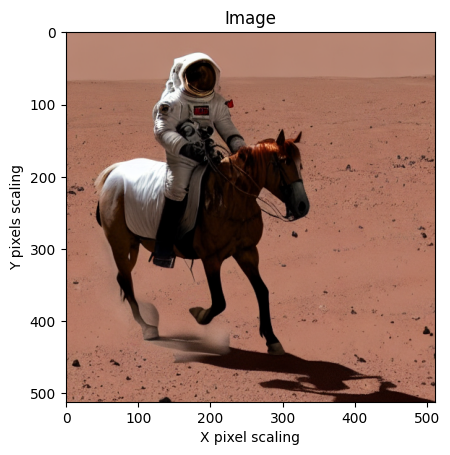

100%|██████████| 50/50 [00:02<00:00, 18.39it/s]


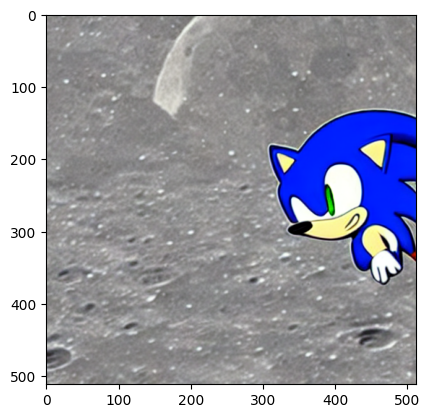

100%|██████████| 50/50 [00:02<00:00, 18.58it/s]


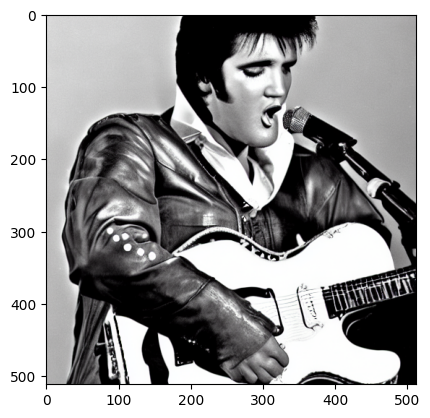

100%|██████████| 50/50 [00:02<00:00, 18.55it/s]


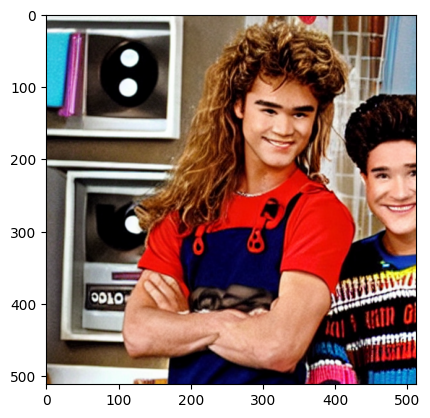

100%|██████████| 50/50 [00:02<00:00, 18.63it/s]


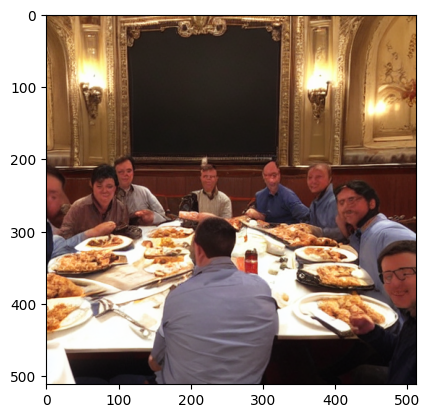

100%|██████████| 50/50 [00:02<00:00, 17.20it/s]


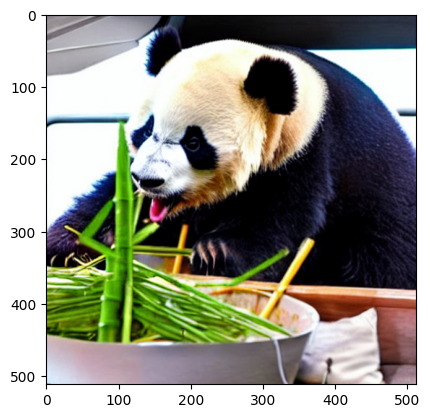

100%|██████████| 50/50 [00:02<00:00, 18.63it/s]


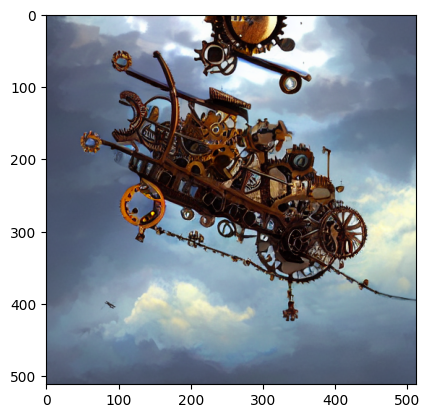

100%|██████████| 50/50 [00:02<00:00, 18.62it/s]


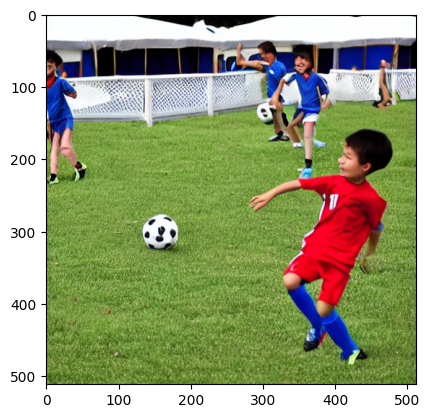

Average time:  2.89 seconds


In [7]:
# --- Load all compiled models ---
COMPILER_WORKDIR_ROOT = 'sd_1_5_fp32_512_compile_workdir'

# Model ID for SD version pipeline
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)

text_encoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder/model.pt')
unet_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'unet/model.pt')
decoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'vae_decoder/model.pt')
post_quant_conv_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'vae_post_quant_conv/model.pt')
safety_model_neuron_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'safety_model_neuron/model.pt')


# Load the compiled UNet onto two neuron cores.
pipe.unet = NeuronUNet(UNetWrap(pipe.unet))
device_ids = [0,1]
pipe.unet.unetwrap = torch_neuronx.DataParallel(torch.jit.load(unet_filename), device_ids, set_dynamic_batching=False)

# Load other compiled models onto a single neuron core.
pipe.text_encoder = NeuronTextEncoder(pipe.text_encoder)
pipe.text_encoder.neuron_text_encoder = torch.jit.load(text_encoder_filename)
pipe.vae.decoder = torch.jit.load(decoder_filename)
pipe.vae.post_quant_conv = torch.jit.load(post_quant_conv_filename)
pipe.safety_checker.vision_model = NeuronSafetyModelWrap(torch.jit.load(safety_model_neuron_filename))

# Run pipeline
prompt = ["a photo of an astronaut riding a horse on mars",
          "sonic on the moon",
          "elvis playing guitar while eating a hotdog",
          "saved by the bell",
          "engineers eating lunch at the opera",
          "panda eating bamboo on a plane",
          "A digital illustration of a steampunk flying machine in the sky with cogs and mechanisms, 4k, detailed, trending in artstation, fantasy vivid colors",
          "kids playing soccer at the FIFA World Cup"
         ]

plt.title("Image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

total_time = 0
for x in prompt:
    start_time = time.time()
    image = pipe(x).images[0]
    total_time = total_time + (time.time()-start_time)
    image.save("image.png")
    image = mpimg.imread("image.png")
    #clear_output(wait=True)
    plt.imshow(image)
    plt.show()
print("Average time: ", np.round((total_time/len(prompt)), 2), "seconds")


**Now have Fun**

Uncomment the cell below for interactive experiment with different prompts.

Enter Prompt, type exit to quit


100%|██████████| 50/50 [00:02<00:00, 18.26it/s]


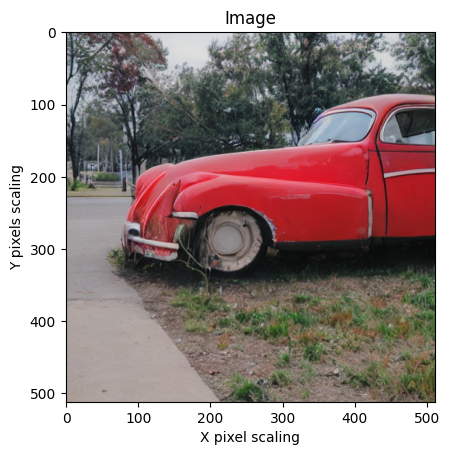

time:  2.9 seconds


100%|██████████| 50/50 [00:02<00:00, 18.63it/s]


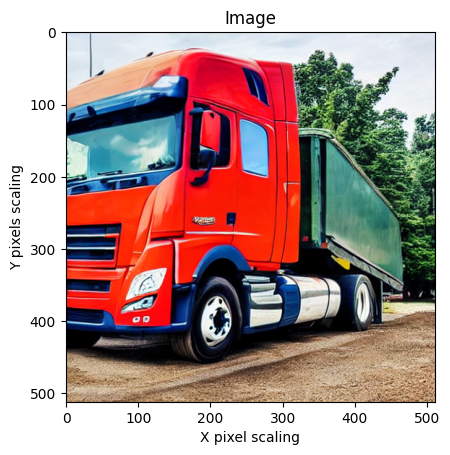

time:  2.85 seconds


100%|██████████| 50/50 [00:02<00:00, 18.65it/s]


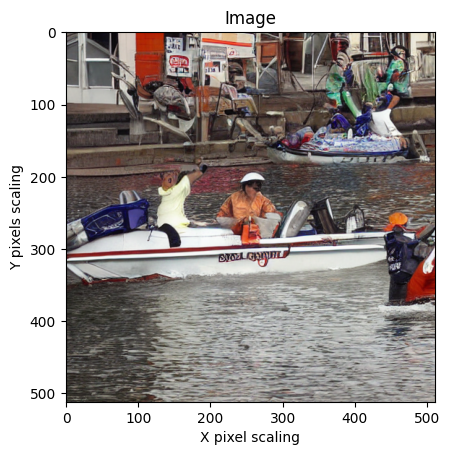

time:  2.85 seconds


In [9]:
user_input = ""
print("Enter Prompt, type exit to quit")
while user_input != "exit": 
    total_time = 0
    user_input = input("What prompt would you like to give?  ")
    if user_input == "exit":
        break
    start_time = time.time()
    image = pipe(user_input).images[0]
    total_time = total_time + (time.time()-start_time)
    image.save("image.png")

    plt.title("Image")
    plt.xlabel("X pixel scaling")
    plt.ylabel("Y pixels scaling")

    image = mpimg.imread("image.png")
    plt.imshow(image)
    plt.show()
    print("time: ", np.round(total_time, 2), "seconds")
